# Group Final Report

Group: 22  
Name: Aparna Varma, Arthur Guo, Guozheng Gong, Norinne  
Course: STAT 301  
Date: **2025-04-13**  

## Introduction

In today’s highly competitive restaurant industry, owners are increasingly turning to data-driven strategies and analyses on variables like menu price, marketing expenditure and customer engagement to increase profitability. *A. K. Sah et al.* explored how restaurant owners can utilize data mining and predictive algorithms to extract insights from past transactional data, enabling them to make personalized menu recommendations to boost customer loyalty and total revenue [1]. *S. Bera* discussed using regression models, specifically linear and ridge regression, to identify trends in annual restaurant revenue and customer food preferences across cities; their research also highlights the potential of these models to detect operational inefficiencies, and their use as business decision tools to maximize profit and scalability [2]. In another study, *S. Gogolev et al.* further examine the challenges of modeling revenues for a Russian resturant chain using simple linear regression, particularly the risk of multicollinearity [3]. Their findings emphasize how multicollinearity can lead to biased predictions, and used Variance Inflation Factor (VIF) and elastic net regularization to detect correlated factors and help improve model reliability [3]. 

Building on this, our project seeks to address two prediction- and inference-oriented main questions:

1. What are the key predictors of a restaurant’s monthly revenue in our dataset?
2. How significant is their influence on prediction?

We aim to understand which variables are most strongly associated with an increase in restaurant revenue. 

To investigate these questions, we analyze a dataset of 1000 observations and 8 variables related to restaurant performance. The dataset includes discrete, continuous and categorical variables such as number of customers, menu price, marketing spend, cuisine type, average customer spending, number of reviews, and whether a promotion was applied. Our response variable is `Monthly_Revenue`, and we will use multiple linear regression with ridge regularization to predict monthly revenue while addressing potential multicollinearity between predictors.

## Methods and Results

### Data

In [1]:
library(tidyverse)
library(broom)
library(tidymodels)
library(glmnet)
library(mltools)

temp <- tempfile()
download.file("https://www.kaggle.com/api/v1/datasets/download/mrsimple07/restaurants-revenue-prediction", temp)
data <- read_csv(unz(temp, "Restaurant_revenue (1).csv"))
head(data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ dials        1.2.1     ✔ rsample      1.2.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ recipes      1.1.0     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter

Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
61,43.11764,12.663793,Japanese,36.23613,0,45,350.9120
24,40.02008,4.577892,Italian,17.95256,0,36,221.3191
81,41.98149,4.652911,Japanese,22.60042,1,91,326.5298
70,43.00531,4.416053,Italian,18.98410,1,59,348.1906
30,17.45620,3.475052,Italian,12.76614,1,30,185.0091
92,19.42767,13.114473,American,43.09995,1,10,399.8675


This dataset contains information about restaurants, their customer activity, marketing efforts, and revenue. It is a simulated dataset designed for exploratory data analysis (EDA) and predictive modeling, particularly for regression tasks. The dataset includes various restaurant characteristics, financial metrics, and customer interactions.

At an initial glance, all variables are meaningful and we do not see any irrelevant variables that should be dropped (such as row numbers or IDs).

#### Dataset Summary
- Number of Observations: 1000
- Number of Variables: 8

#### Variable Description
| Variable Name               | Description                                                        | Type                      |
|----------------------------|--------------------------------------------------------------------|---------------------------|
| Number_of_Customers        | Number of customers visiting the restaurant.                       | Numeric (Discrete)        |
| Menu_Price                 | Average price of menu items.                                       | Numeric (Continuous)      |
| Marketing_Spend            | Amount spent on marketing activities.                              | Numeric (Continuous)      |
| Cuisine_Type               | Type of cuisine offered (e.g., Italian, Japanese).                 | Categorical               |
| Average_Customer_Spending  | Average amount spent by a customer per visit.                      | Numeric (Continuous)      |
| Promotions                 | Indicates whether a promotion was run (0 = No, 1 = Yes).           | Categorical (Binary)      |
| Reviews                    | Number of reviews received by the restaurant.                      | Numeric (Discrete)        |
| Monthly_Revenue            | Total revenue generated by the restaurant in a month.              | Numeric (Continuous)      |

Source: MrSimple07. (2024). Restaurants Revenue Prediction [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/7420974

Credit: Norinne's individual assignment.

### Exploratory Data Analysis (EDA)

In [2]:
# Convert categorical features into factor data types.
work_data <- mutate(data, Cuisine_Type = as_factor(Cuisine_Type), Promotions = as_factor(Promotions))
head(work_data)

# Credit: Arthur's individual assignment.

Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
61,43.11764,12.663793,Japanese,36.23613,0,45,350.9120
24,40.02008,4.577892,Italian,17.95256,0,36,221.3191
81,41.98149,4.652911,Japanese,22.60042,1,91,326.5298
70,43.00531,4.416053,Italian,18.98410,1,59,348.1906
30,17.45620,3.475052,Italian,12.76614,1,30,185.0091
92,19.42767,13.114473,American,43.09995,1,10,399.8675


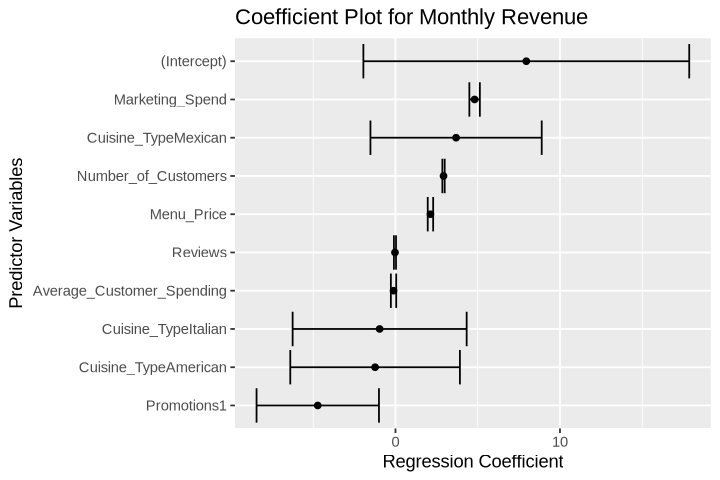

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)

model <- lm(Monthly_Revenue ~ ., data = work_data)
ggplot(tidy(model), aes(x = estimate, y = reorder(term, estimate))) +
  geom_point() +
  labs(x = "Regression Coefficient", y = "Predictor Variables", title = "Coefficient Plot for Monthly Revenue")+
  geom_errorbarh(aes(xmin = estimate - std.error, xmax = estimate + std.error))

This coefficient plot visualizes the estimated impact of each predictor on monthly revenue, along with the associated uncertainty, allowing for a clear assessment of which variables are most influential in the context of a multiple linear regression model.  

It looks like `Marketing_Spend`, `Number_of_Customers`, and `Menu_Price` may be associated with increasing monthly revenue.  

Credit: Guozheng's individual assignment.

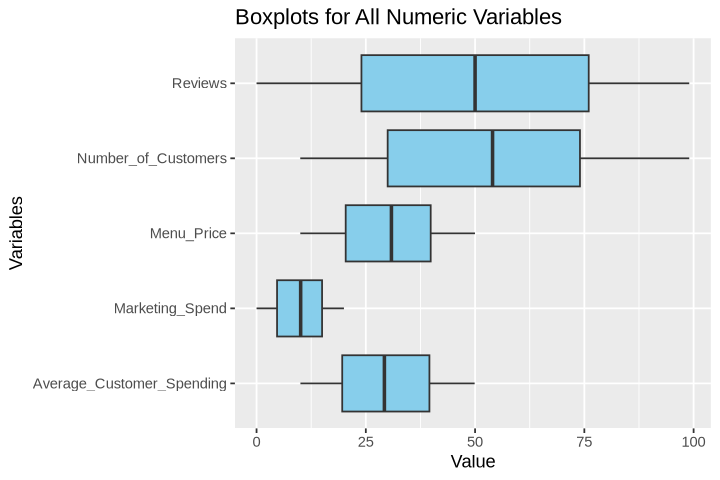

In [4]:
numeric_vars <- pivot_longer(work_data[, sapply(work_data, is.numeric)], cols = !Monthly_Revenue,
                          names_to = "Variable", values_to = "Value")
ggplot(numeric_vars, aes(x = Variable, y = Value)) +
  geom_boxplot(fill = "skyblue") +
  coord_flip() +
  labs(title = "Boxplots for All Numeric Variables",
       y = "Value", x = "Variables")

This boxplot was created to visually inspect all numeric predictor variables (excluding `Monthly_Revenue`) for potential outliers and distributional differences.  

From this graph, we can see that none of the variables show extreme outliers because there are no dots far beyond the whiskers. It suggests that the dataset is relatively clean and does not contain obvious outlier values for these predictors.

In summary, there are no missing values in our dataset and the distribution of the data seems reasonably well-behaved. Hence, there is little need for initial tidying or pre-processing, and we will keep all columns for the next step.

### Methods: Plan

### Proposed Method: 
We will be using multiple linear regression with ridge regularization to generate a model that can predict monthly revenue. 

**1. Data Preprocessing:**

- Splitting the data into training (80%) and testing (20%) sets.
- Removing any unwanted columns (eg ID) 

**2. Feature Selection** 

- Ridge Regression will be applied to shrink coefficient estimates.
- This helps reduce the impact of multicollinearity by penalizing large coefficients and distributing the effect across correlated variables.
- The values for Lambda will be selected using cross-validation.
- The final model will retain all features but with shrunk coefficients that reflect their relative importance. 

**3. Model Training and Evaluation:**

- A MLR model with ridge penalty will be trained using the selected lambda
- The model's performance will be evaluated using R^2 and RMSE on a test set to assess generalization performance. 

**Why this method?** <br>

The dataset includes several variables that may contain overlapping information. For example, a restaurant with higher menu prices may have higher customer spending. These relationships can cause multicollinearity which Ridge Regression addresses by shrinking the coefficients of correlated predictors. This method is particularly useful in situations where all variables are to be retained in the model but need to be regularized to avoid overfitting.

**Assumptions of the Model** 

- Linearity: The relationship between independent variables and revenue should be linear.
- Independence: Observations should not be correlated
- Normality of Residuals: Residuals should be approximately normally distributed.
- Equal Variance (Homoscedasticity): Residuals should have constant variance.

**Limitations**

- Ridge regression does not eliminate variables, which may reduce simplicity and interpretability.
- If important patterns in the data are non-linear, a linear model may not capture them fully.
- The interpretation of coefficients is limited due to regularization, especially when there are dummy variables.

### Computational Code

In [5]:
set.seed(1234) 

split <- initial_split(data, prop = 0.8, strata = Monthly_Revenue)

train_data <- training(split)
test_data  <- testing(split)

head(train_data)
head(test_data)
cat('Training data has', nrow(train_data), 'rows\n')
cat('Testing data has', nrow(test_data), 'rows')

Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
12,28.07794,7.084725,American,39.78947,0,20,189.2389
47,33.09945,4.971605,American,22.69222,1,92,182.9190
31,23.31263,6.470008,Italian,19.70313,0,25,165.8842
24,32.92603,5.317023,Japanese,11.23724,1,4,178.3033
12,29.75926,13.034213,Italian,14.86781,0,75,116.7905
16,14.11664,12.281626,Italian,22.64311,0,4,138.2032


Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
24,40.02008,4.577892,Italian,17.95256,0,36,221.31909
70,43.00531,4.416053,Italian,18.98410,1,59,348.19057
30,17.45620,3.475052,Italian,12.76614,1,30,185.00912
84,46.31465,14.486349,Italian,28.92110,1,1,417.15861
11,34.96406,3.537743,Mexican,30.52700,0,51,117.15333
11,24.21450,2.676075,Italian,46.47838,1,19,60.37322


Training data has 800 rows
Testing data has 200 rows

In [6]:
# build model matrix 
X_train <- model.matrix(Monthly_Revenue ~ ., data = train_data)[, -1]
y_train <- train_data$Monthly_Revenue

X_test <- model.matrix(Monthly_Revenue ~ ., data = test_data)[, -1]
y_test <- test_data$Monthly_Revenue

In [7]:
# perform ridge regression with cross-validation

set.seed(1234)  

ridge_model <- cv.glmnet(
  x = X_train,
  y = y_train,
  alpha = 0, 
  lambda = exp(seq(-5, 10, 0.1)) #select lambda value (adapted from tutorial 8)  
)

In [8]:
best_lambda <- ridge_model$lambda.min
cat("chosen lambda:", round(best_lambda, 5), "\n")

chosen lambda: 0.74082 


In [9]:
ridge_coefs <- coef(ridge_model, s = "lambda.min")

# display coefficient table
coef_table <- tibble(
  Feature = rownames(ridge_coefs),
  Coefficient = as.vector(ridge_coefs)
)

coef_table
glance(ridge_model)

Feature,Coefficient
<chr>,<dbl>
(Intercept),8.64416858
Number_of_Customers,2.87409354
Menu_Price,2.17188933
Marketing_Spend,4.76292039
Cuisine_TypeItalian,-4.26437602
Cuisine_TypeJapanese,1.67297990
Cuisine_TypeMexican,0.15641737
Average_Customer_Spending,0.01945169
Promotions,-5.81096011


lambda.min,lambda.1se,nobs
<dbl>,<dbl>,<int>
0.7408182,16.44465,800


In [10]:
# make predictions on test set
predictions <- predict(ridge_model, newx = X_test, s = "lambda.min")

In [11]:
# compute rmse
rmse <- sqrt(mean((y_test - predictions)^2))
cat("rmse:", round(rmse, 2), "\n")

# compute r^2
ss_res <- sum((y_test - predictions)^2)
ss_tot <- sum((y_test - mean(y_test))^2)
r_squared <- 1 - ss_res / ss_tot
cat("r-squared:", round(r_squared, 4), "\n")

rmse: 56.45 
r-squared: 0.7007 


In [12]:
metrics <- tibble(
  Metric = c("Chosen Lambda", "RMSE", "R^2"),
  Value = c(round(best_lambda, 5), round(rmse, 2), round(r_squared, 4))
)

metrics

Metric,Value
<chr>,<dbl>
Chosen Lambda,0.74082
RMSE,56.45000
R^2,0.70070


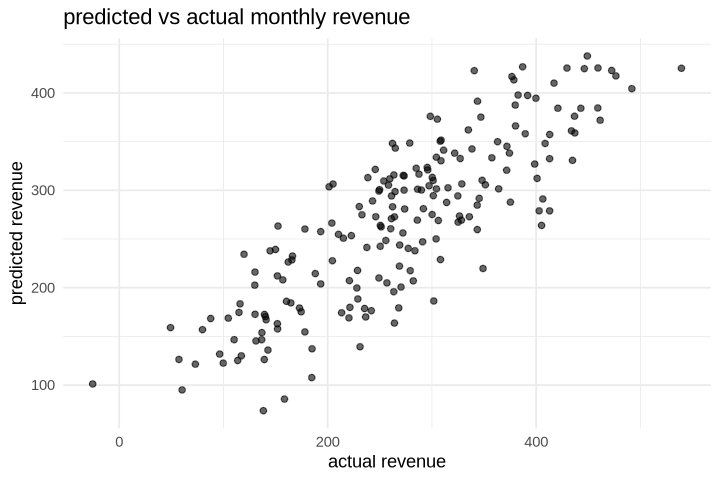

In [13]:
# plot predicted vs actual revenue
plot_df <- tibble(
  Actual = y_test,
  Predicted = as.vector(predictions)
)

ggplot(plot_df, aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.6) +
  labs(
    title = "predicted vs actual monthly revenue",
    x = "actual revenue",
    y = "predicted revenue"
  ) +
  theme_minimal()

## Discussion

First, let's summarize our results. Our final model achieved the following results on the test set

| metric | value   |
| ------ | ------- |
| lambda | 0.74082 |
| rmse   | 56.45   |
| r2     | 0.7007  |

and has the following coefficients.

| feature                     | coefficient |
| --------------------------- | ----------- |
| intercept                   | 8.64416858  |
| `Number_of_Customers`       | 2.87409354  |
| `Menu_Price`                | 2.17188933  |
| `Marketing_Spend`           | 4.76292039  |
| `Cuisine_TypeItalian`       | -4.26437602 |
| `Cuisine_TypeJapanese`      | 1.67297990  |
| `Cuisine_TypeMexican`       | 0.15641737  |
| `Average_Customer_Spending` | 0.01945169  |
| `Promotions`                | -5.81096011 |
| `Reviews`                   | -0.07256761 |

Now, let's discuss the results.

Our model achieved an RMSE of 56.45 on the test dataset. This is a bit difficult to interpret, as we are not given units for any of the variables (the dataset is simulated, after all). Alternatively, we achieved an R^2 score of 0.70. This can be interpreted as the model being able to "explain" approximately 70% of the variance in the data, which is overall a fairly good result.

Because we evaluated the model on a randomly selected partition of the dataset, the test dataset had no influence on the training phase of the model. Furthermore, we reduced the impact of optimization bias by using cross-validation on the training dataset to tune the hyperparameter *lambda* and select the model. In general, we would expect this level of performance to generalize well to unseen data.

The interpretation for the coefficients ends up being rather formulaic---our model is already quite simple in principle, and since we don't have any units, it is difficult to tie our results back to a real-world context. Nonetheless, we will give some examples of coefficient interpretations and related intuition for certain variables below. We will say that the interpretations for the rest of the variables are all very similar to these examples.

- A unit increase in the number of customers is associated with a 2.87 unit increase in monthly revenue. Intuitively, this aligns with expectations as more paying customers should lead to more revenue.
- A unit increase in marketing expenditure is associated with a 4.76 unit increase in monthly revenue. This also makes sense, and it suggests that as a restaurant owner, investing in marketing is likely to produce a great return on investment.
- A unit increase in the number of reviews is associated with a 0.07 unit decrease in monthly revenue. This is a bit less intuitive, but still somewhat understandable. The coefficient is also rather close to zero, so we should be wary and think about whether this is statistically significant or attributed to random noise.
- For cuisine type, the baseline category is "American". Compared to the baseline, a restaurant that serves Italian cuisine is expected to see a 4.26 unit decrease in monthly revenue. This is an interesting result and intuitively, this might suggest that opening an Italian restaurants is an unwise business decision.
- For promotions, the baseline category is 0, for no promotions. Compared to the baseline, a restaurant that does promotions is expected to see a 5.81 unit decrease in monthly revenue. Intuitively, this also aligns with expectations as customers using the promotion would spend less overall, and restaurants are more likely to offer promotions if they are already struggling.
- The baseline monthly revenue when all variables are zero is 8.64. Without units or normalizing the data, it is hard to say any more about the intercept.

Now, let's elaborate a bit more on the qualities of the model and their implications as well.

The regularization strength (defined by the *lambda* hyperparameter) of 0.74 encourages the model to have small weights for the features, which counteracts overfitting and thereby improves the performance on unseen data. Note that we used ridge (L2) regularization rather than LASSO or elastic net, but L2 regularization by itself does not remove variables from the model. Hence, our model has not gone through any feature selection process and therefore uses all 7 of the original predictor variables.

Note that while regularization can be extremely beneficial in terms of prediction by combatting overfitting and producing a generalizable model, it tends to complicate matters on the inference side. Regularization inherently introduces bias to the coefficients (by penalizing models with large weights, they are biased towards zero). As a result, our typical strategy of gauging statistical significance by examining p-values does not work here---in fact, we don't have any p-values to examine at all. The best we can do for inference given our chosen method is to look at the relative magnitudes of the coefficients as a estimate for feature importance. However, this is not a particularly rigorous approach and other factors such as the relative scale of each variable will affect the magnitude of the coefficient. In any case, we tentatively claim that some of the features with a strong influence on the prediction are `Marketing_Spend`, `Menu_Price`, and `Number_of_Customers`.

Finally, let's think about next steps, improvements, and areas to investigate further.

By producing a model that explains about 70% of the variance in the data, we addressed our prediction-oriented research question reasonably well. However, the remaining 30% of variance suggests that there is still room for improvement. Given more time and an increased scope, we might try pre-processing the data or fitting and comparing a wider variety of models (such as different families of generalized linear models, or even non-linear models) in the hopes of obtaining a model with better performance.

Additionally, while we did make some progress on our inference-related question, our choice of method prevents us from giving a confident answer. One possible way to continue in this direction would be to conduct another round of feature selection using stepwise methods or LASSO, and fit a new ordinary least squares model with the selected features on a new partition of the data in order to obtain interpretable p-values. This would inform a more definitive answer as to which features are statistically significant predictors. 

In terms of further research, we did discover some interesting results that merit further investigation. Due to the simulated nature of our dataset, we can't be sure if these findings actually correspond to real-world phenomena. Let's assume that they do for the sake of discussion. Then why do Italian restaurants seem to underperform so severely in terms of monthly revenue when compared to other cuisine types? Additionally, is it really true in general that promotions are bad for revenue, or can they be used strategically to improve business? Further studies in these areas could lead to helpful real-world insights for restaurant owners.

### References

1. A. K. Sah and V. K, "Predictive Modeling for Restaurant Menu Customization: An FP-Growth Algorithm-Based Solution," 2024 IEEE International Students' Conference on Electrical, Electronics and Computer Science (SCEECS), Bhopal, India, 2024, pp. 1-6,     https://doi.org/10.1109/SCEECS61402.2024.10482175.
   
2. Bera, S, “ An Application of Operational Analytics: For Predicting Sales Revenue of Restaurant” (2021). In: Das, S., Das, S., Dey, N., Hassanien, AE. (eds) Machine Learning Algorithms for Industrial Applications. Studies in Computational Intelligence, vol 907. Springer, Cham. https://doi.org/10.1007/978-3-030-50641-4_13

   
3. Gogolev, S., Ozhegov, E.M. “Comparison of Machine Learning Algorithms in Restaurant Revenue Prediction” (2020). In: van der Aalst, W., et al. Analysis of Images, Social Networks and Texts. AIST 2019. Communications in Computer and Information Science, vol 1086. Springer, Cham. https://doi.org/10.1007/978-3-030-39575-9_4